In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits
import scipy.interpolate

import sys
sys.path.append("../src/")
import pseudo_Cls
import utils

pi = np.pi

import importlib

# Test power spectrum routines

Make sure pseudo Cl estimator and Gaussian randomfield creator are consistent. Also check that the total variance matches.

In [3]:
importlib.reload(pseudo_Cls)
importlib.reload(utils)

L = 10/180*pi
n = 500

ell_min = 100
ell_max = 2*pi/L*n/2
n_bin = 5
logspaced = True

n_realisation = 50

def spectrum(ell):
    ell_0 = 500
    return 1/(ell/ell_0*(1+(ell/ell_0)**2))
    #return ell**-1
    #return np.ones_like(ell)

pCl = np.zeros((n_realisation, n_bin))

for i in range(n_realisation):
    random_map = pseudo_Cls.create_Gaussian_field(spectrum, (n, n), (L, L))
    Cl, Cl_err, ell_mean, bin_edges, _ = pseudo_Cls.calculate_pseudo_Cl(random_map, random_map, (L, L), 
                                         n_bin=n_bin, ell_min=ell_min, ell_max=ell_max, logspaced=logspaced)
    pCl[i] = Cl

/Users/yooken/miniconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide


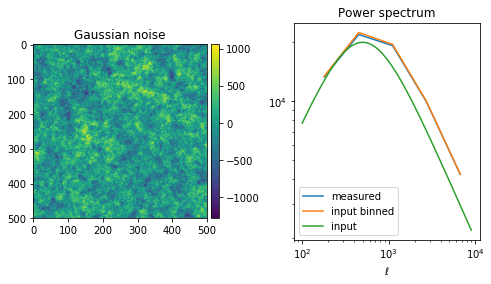

In [4]:
fig, plots = plt.subplots(1, 2, figsize=(8, 4))
fig.subplots_adjust(wspace=0.4)

im = plots[0].imshow(random_map, interpolation="nearest")
utils.subplot_colorbar(im, plots[0])
plots[0].set_title("Gaussian noise")

units = ell_mean*(ell_mean+1)/(2*pi)

Cl = np.mean(pCl, axis=0)
Cl_err = np.sqrt(np.var(pCl, axis=0)/n_realisation)

plots[1].loglog(ell_mean, units*Cl, label="measured")
#plots[1].loglog(ell, (units*pCl).T, c="C0", alpha=0.2)
# plots[1].fill_between(ell_mean, units*(Cl-Cl_err), 
#                              units*(Cl+Cl_err),
#                         alpha=0.3)

ell = np.arange(ell_min, ell_max+1)
Cl_theory, _, _ = utils.bin_array(spectrum(ell), ell, bin_edges=bin_edges, weights=ell)
plots[1].loglog(ell_mean, units*Cl_theory, label="input binned")

units = ell*(ell+1)/(2*pi)

plots[1].loglog(ell, units*spectrum(ell), label="input")
plots[1].legend()
plots[1].set_xlabel(r"$\ell$")

plots[1].set_title("Power spectrum")


In [6]:
random_map = pseudo_Cls.create_Gaussian_field(spectrum, (n, n), (L, L))
Cl, _, ell_mean, _, _ = pseudo_Cls.calculate_pseudo_Cl(random_map, random_map, (L, L), 
                                         n_bin=None)

print(np.var(random_map))
print(np.trapz(ell_mean*Cl, ell_mean)/(2*pi))


55377.7261623
54079.2890247


/Users/yooken/miniconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide


/Users/yooken/miniconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in power


AttributeError: module 'utils' has no attribute 'rebin'

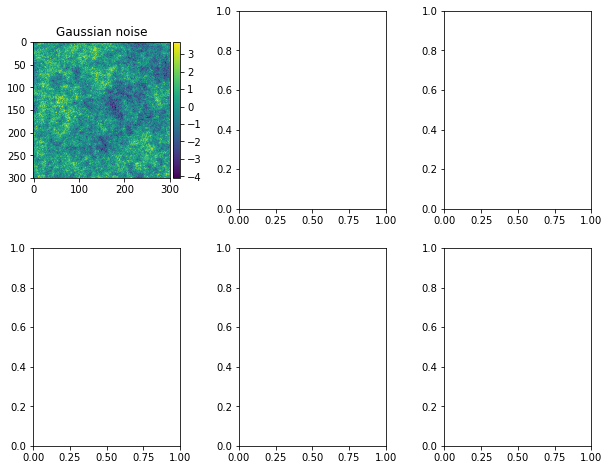

In [7]:
importlib.reload(pseudo_Cls)
importlib.reload(utils)

L = 5/180*pi
n = 300

# Weak lensing shape noise
sigma_e = 0.28
n_eff = 5.84
Cl_shape_noise = lambda ell: np.ones_like(ell)*sigma_e**2/(n_eff*60**2/(1/180*pi)**2)#*np.exp(-0.5*RCSLenS_kappa_smoothing**2*ell**2)**2

# CMB lensing noise
ell_Planck_data, N_ell_raw, N_C_ell_raw = np.loadtxt("./data/nlkk.dat", unpack=True)
Cl_CMB_noise = scipy.interpolate.UnivariateSpline(ell_Planck_data, N_ell_raw, s=0, k=1, ext=3)

def spectrum(ell):
    return ell**-2

with astropy.io.fits.open("./data/AGN_TUNED_nu0_L400N1024_WMAP9_cone_0_kappa_kids_image_ngp.fits") as hdu:
    kappa_map = hdu[0].data    

noise_map = pseudo_Cls.create_Gaussian_field(spectrum, (n, n), (L, L))

zoom_factor = 6
smoothing_scale = 5/60/180*pi # 5 arcmin in radian

processed_kappa_map, new_map_size = pseudo_Cls.process_map(kappa_map, 
                                        [{"type" : "zoom", "zoom_factor" : 1/zoom_factor},
                                         {"type" : "smoothing", "sigma" : smoothing_scale, "mode" : "wrap"}],
                                        (L, L))

noise_pCl = pseudo_Cls.calculate_pseudo_Cl(noise_map, noise_map, (L, L), 
                                         n_bin=10, ell_min=100, ell_max=10000, logspaced=True)
kappa_map_pCl = pseudo_Cls.calculate_pseudo_Cl(kappa_map, kappa_map, (L, L), 
                                             n_bin=10, ell_min=100, ell_max=10000, logspaced=True)
processed_kappa_map_pCl = pseudo_Cls.calculate_pseudo_Cl(processed_kappa_map, processed_kappa_map, (L, L), 
                                                       n_bin=10, ell_min=100, ell_max=10000, logspaced=True)

fig, plots = plt.subplots(2, 3, figsize=(10, 8))
fig.subplots_adjust(wspace=0.4)

im = plots[0,0].imshow(noise_map, interpolation="nearest")
utils.subplot_colorbar(im, plots[0,0])
plots[0,0].set_title("Gaussian noise")

im = plots[0,1].imshow(utils.rebin_2d(kappa_map, (300, 300)), interpolation="nearest")
utils.subplot_colorbar(im, plots[0,1])
plots[0,1].set_title("Kappa map")

im = plots[0,2].imshow(processed_kappa_map, interpolation="nearest")
utils.subplot_colorbar(im, plots[0,2])
plots[0,2].set_title("Kappa map processed")

ell = noise_pCl[2]
units = ell*(ell+1)/(2*pi)
plots[1,0].loglog(ell, units*noise_pCl[0], label="measured")
plots[1,0].fill_between(ell, units*(noise_pCl[0]-np.sqrt(noise_pCl[5])), 
                             units*(noise_pCl[0]+np.sqrt(noise_pCl[5])),
                        alpha=0.3)

plots[1,0].loglog(ell, units*spectrum(ell), label="input")
plots[1,1].loglog(ell, units*kappa_map_pCl[0])
plots[1,2].loglog(ell, units*processed_kappa_map_pCl[0])

for p in plots[1]:
    p.set_xlabel(r"$\ell$")
    p.set_ylabel(r"$\ell(\ell+1)/2\pi C_\ell$")
    p.legend()